In [11]:
import glob
import pandas as pd

In [12]:
pos_train = glob.glob("aclImdb/train/pos/*.txt")
neg_train = glob.glob("aclImdb/train/neg/*.txt")
pos_test = glob.glob("aclImdb/test/pos/*.txt")
neg_test = glob.glob("aclImdb/test/neg/*.txt")

In [13]:
def getlabeleddata(input_data):
    text_list = []
    
    for i in range(len(input_data)):
        fp = open(input_data[i],'r')
        text_list.append(fp.read())
        fp.close()
        
    return text_list

In [14]:
pos_train_df = pd.DataFrame(getlabeleddata(pos_train))
neg_train_df = pd.DataFrame(getlabeleddata(neg_train))
pos_test_df = pd.DataFrame(getlabeleddata(pos_test))
neg_test_df = pd.DataFrame(getlabeleddata(neg_test))

In [15]:
pos_train_df['polarity'] = 1
neg_train_df['polarity'] = 0
pos_test_df['polarity'] = 1
neg_test_df['polarity'] = 0

In [16]:
pos_train_df.rename(columns={0: "text"}, inplace=True)
neg_train_df.rename(columns={0: "text"}, inplace=True)
pos_test_df.rename(columns={0: "text"}, inplace=True)
neg_test_df.rename(columns={0: "text"}, inplace=True)

In [17]:
train = pd.concat([pos_train_df, neg_train_df])

In [18]:
test = pd.concat([pos_test_df, neg_test_df])

#### Combine train and test data while shuffling

In [19]:
df = pd.concat([train,test])
df = df.sample(frac=1).reset_index(drop=True)

### Cleaning Text

#### Lower Case:

In [20]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#### Remove Punctuation:

In [21]:
df['text'] = df['text'].str.replace('[^\w\s]','')

#### Remove StopWords:

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [24]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#### Common Word Removal:

In [25]:
freq = pd.Series(' '.join(train['text']).split()).value_counts()[:10]

In [26]:
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

#### Rare Word Removal:

In [27]:
freq = pd.Series(' '.join(train['text']).split()).value_counts()[-10:]

In [28]:
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

#### Correct the Spelling

In [29]:
from textblob import TextBlob
df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    whole exercise painless make film lighting gha...
1    always soft spot dinner flick another part liv...
2    certainly film everybodybut anyone sense humor...
3    america land freedom hope dreams nation since ...
4    simply give three fulfilled bodies hoped would...
Name: text, dtype: object

#### Split df into train/test for vectorizor models

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train, test = train_test_split(df, test_size = 0.2)

### Vectorizers:

#### Vectorize Text using CountVectorizer()

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing import sequence

Using TensorFlow backend.


In [114]:
top_words = 10000

In [115]:
vect_count = CountVectorizer(stop_words='english', max_features=top_words)
x_train_count = vect_count.fit_transform(train['text'])
x_test_count = vect_count.transform(test['text'])

In [116]:
x_train_count.shape, x_test_count.shape

((40000, 10000), (10000, 10000))

#### Vectorise Text using TF-IDF:

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
vect_tfidf = TfidfVectorizer(stop_words='english', max_features=top_words)
x_train_tfidf = vect_tfidf.fit_transform(train['text'])
x_test_tfidf = vect_tfidf.transform(test['text'])

In [119]:
x_train_tfidf.shape, x_test_tfidf.shape

((40000, 10000), (10000, 10000))

#### Vectorize using HashingVectorizer

In [120]:
from sklearn.feature_extraction.text import HashingVectorizer

In [121]:
vect_hash = HashingVectorizer(stop_words='english', n_features=top_words)
x_train_hash = vect_hash.fit_transform(train['text'])
x_test_hash = vect_hash.transform(test['text'])

#### Test on Machine Learning Models

In [122]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [123]:
def getmodel(classifier, train_vect_data, test_vect_data, train_target, test_target):
    
    history = classifier.fit(train_vect_data, train_target)
    predict_target = pd.Series(classifier.predict(test_vect_data))
    
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    metrics['Accuracy'] = [accuracy_score(test_target, predict_target)]
    metrics['Precision'] = [precision_score(test_target, predict_target)]
    metrics['Recall'] = [recall_score(test_target, predict_target)]
    metrics['F1'] = [f1_score(test_target, predict_target)]
    
    stats = metrics.sort_values('F1', ascending = False)
    
    return classifier, stats, history

#### Bernoulli - Count Vectorizer

In [104]:
bernooulli_count, stats, null = getmodel(BernoulliNB(), x_train_count, x_test_count, train['polarity'], test['polarity'])
stats.head()

,Accuracy,Precision,Recall,F1
0,0.8548,0.855588,0.847578,0.851564


#### K Neighbors  - Count Vectorizer

In [109]:
kneighbors_count, stats, null = getmodel(KNeighborsClassifier(), x_train_count, x_test_count, train['polarity'], test['polarity'])
stats.head()

,Accuracy,Precision,Recall,F1
0,0.6035,0.617305,0.50814,0.557428


#### Gradient Boosting - Count Vectorizer

In [110]:
gradientboost_count, stats, null = getmodel(GradientBoostingClassifier(), x_train_count, x_test_count, train['polarity'], test['polarity'])
stats.head()

,Accuracy,Precision,Recall,F1
0,0.8028,0.761279,0.872202,0.812974


#### RandomForest - Count Vectorizer

In [112]:
randomforest_count, stats, null = getmodel(RandomForestClassifier(), x_train_count, x_test_count, train['polarity'], test['polarity'])
stats.head()

,Accuracy,Precision,Recall,F1
0,0.8503,0.847468,0.847985,0.847727


### Using Deep Learning Classification:

#### Using Tokenizer to create reduce input embedding layer

In [130]:
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, LSTM, SimpleRNN
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.preprocessing import sequence
from keras.models import Sequential

In [158]:
from keras.preprocessing.text import Tokenizer

In [171]:
max_words = 500

In [178]:
tokenizer = Tokenizer(num_words = top_words)
tokenizer.fit_on_texts(train['text'])

In [179]:
train_tok = tokenizer.texts_to_sequences(train['text'])
test_tok = tokenizer.texts_to_sequences(test['text'])

In [180]:
train_tok = sequence.pad_sequences(train_tok, maxlen=max_words)
test_tok = sequence.pad_sequences(test_tok, maxlen=max_words)

In [181]:
train_tok.shape, test_tok.shape

((40000, 500), (10000, 500))

#### GetMetrics Utitlity Function:

In [224]:
def GetMetrics(model, y_test):
    
    prediction = model.predict(test_tok)
    y_pred = [1 if prediction[i][0]> .5 else 0 for i in range(len(prediction))]
    
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    metrics['Precision'] = [precision_score(y_test, y_pred)]
    metrics['Recall'] = [recall_score(y_test, y_pred)]
    metrics['F1'] = [f1_score(y_test, y_pred)]
    
    stats = metrics.sort_values('F1', ascending = False)
    return stats

#### Visualize Model Training History:

In [226]:
def plothistory(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Params for Embedding: 
Dictate the input layer size: Output of embedding will be 500 vectors (max_words) of 32 dimensions (embedding_vector_length) each.  This output will get flattened to 500 *32 element vector for the next layer to receive. 

#### MLP with count vectorizer

In [186]:
def getMLPModel():
    model = Sequential()
    embedding_vector_length = 32
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_words))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [187]:
mlp = getMLPModel()
mlp.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_8 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               2048128   
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 2,384,769
Trainable params: 2,384,769
Non-trainable params: 0
_________________________________________________________________


In [188]:
history = mlp.fit(train_tok, train['polarity'], validation_data=(test_tok, test['polarity']), epochs=10, batch_size=128)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 14s 356us/step - loss: 0.3818 - accuracy: 0.8089 - val_loss: 0.2578 - val_accuracy: 0.8930
Epoch 2/10
40000/40000 [==============================] - 13s 336us/step - loss: 0.1505 - accuracy: 0.9462 - val_loss: 0.2936 - val_accuracy: 0.8860
Epoch 3/10
40000/40000 [==============================] - 14s 339us/step - loss: 0.0343 - accuracy: 0.9906 - val_loss: 0.4390 - val_accuracy: 0.8768
Epoch 4/10
40000/40000 [==============================] - 14s 341us/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.6422 - val_accuracy: 0.8811
Epoch 5/10
40000/40000 [==============================] - 13s 336us/step - loss: 4.7522e-04 - accuracy: 1.0000 - val_loss: 0.7079 - val_accuracy: 0.8806
Epoch 6/10
40000/40000 [==============================] - 14s 349us/step - loss: 7.8150e-05 - accuracy: 1.0000 - val_loss: 0.7775 - val_accuracy: 0.8805
Epoch 7/10
40000/40000 [========================

In [225]:
GetMetrics(mlp, test['polarity'])

,Accuracy,Precision,Recall,F1
0,0.8816,0.874047,0.886854,0.880404


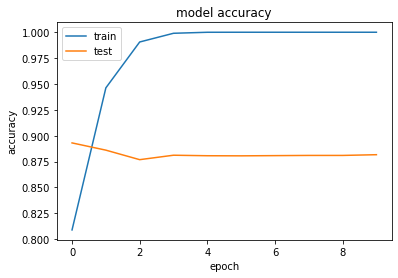

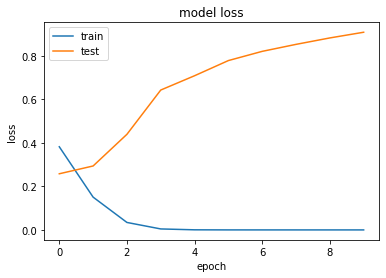

In [227]:
plothistory(history)

In [232]:
def getCNNModel():
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_words))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [233]:
CNN = getCNNModel()
CNN.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 32)           320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 498, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 247, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 123, 32)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3936)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)               

In [235]:
cnn_history = CNN.fit(train_tok, train['polarity'], validation_data=(test_tok, test['polarity']), epochs=10, batch_size=128)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 33s 826us/step - loss: 0.3051 - accuracy: 0.8748 - val_loss: 0.2675 - val_accuracy: 0.8869
Epoch 2/10
40000/40000 [==============================] - 33s 830us/step - loss: 0.2005 - accuracy: 0.9214 - val_loss: 0.2793 - val_accuracy: 0.8892
Epoch 3/10
40000/40000 [==============================] - 33s 823us/step - loss: 0.1518 - accuracy: 0.9438 - val_loss: 0.3130 - val_accuracy: 0.8831
Epoch 4/10
40000/40000 [==============================] - 33s 823us/step - loss: 0.1026 - accuracy: 0.9640 - val_loss: 0.3768 - val_accuracy: 0.8797
Epoch 5/10
40000/40000 [==============================] - 33s 825us/step - loss: 0.0645 - accuracy: 0.9789 - val_loss: 0.4804 - val_accuracy: 0.8734
Epoch 6/10
40000/40000 [==============================] - 33s 824us/step - loss: 0.0364 - accuracy: 0.9893 - val_loss: 0.6182 - val_accuracy: 0.8737
Epoch 7/10
40000/40000 [==============================] 

In [236]:
GetMetrics(CNN, test['polarity'])

,Accuracy,Precision,Recall,F1
0,0.8689,0.860661,0.874847,0.867696


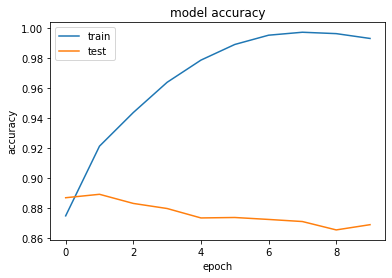

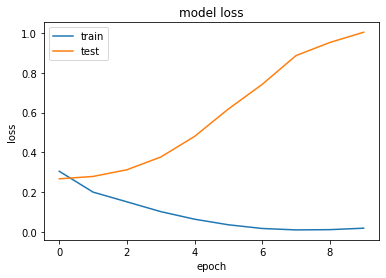

In [237]:
plothistory(cnn_history)

In [ ]:
def getRNNModel():
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_words))
    model.add(Flatten())
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
def getLSTM():
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_words))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model